# **Evaluating NdLinear: Shrinking Neural Networks**

### **Objective: See NdLinear's improvements and how well it performs compared to the standard Linear layer.**



In [1]:
!rm -rf NdLinear
!git clone https://github.com/ensemble-core/NdLinear.git

Cloning into 'NdLinear'...
remote: Enumerating objects: 26, done.
remote: Counting objects: 100% (26/26), done.
remote: Compressing objects: 100% (25/25), done.
remote: Total 26 (delta 5), reused 11 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (26/26), 60.40 KiB | 1.02 MiB/s, done.
Resolving deltas: 100% (5/5), done.


In [2]:
import sys
import importlib.util

# Step 1: Define path to the actual file
ndlinear_path = "/content/NdLinear/ndlinear.py"

# Step 2: Load it dynamically
spec = importlib.util.spec_from_file_location("ndlinear_module", ndlinear_path)
ndlinear_module = importlib.util.module_from_spec(spec)
spec.loader.exec_module(ndlinear_module)

# Step 3: Grab the class
NdLinear = ndlinear_module.NdLinear


**Step 1: Load the data (images)**

In [3]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# I need to change format and data type of the picture so PyTorch can use it
transform = transforms.ToTensor()

# Here, I download the MNIST training and test sets
train_dataset = datasets.MNIST(root='data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='data', train=False, download=True, transform=transform)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)



100%|██████████| 9.91M/9.91M [00:00<00:00, 30.3MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 855kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 7.72MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 4.19MB/s]


I want to visualize the before and after transformation images, just to get a feel of the images we are working with.

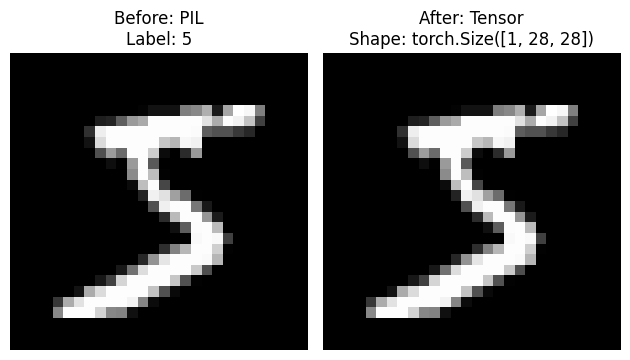

Before (PIL): <class 'PIL.Image.Image'>
After (Tensor): <class 'torch.Tensor'> with shape torch.Size([1, 28, 28])


In [4]:
from torchvision import datasets
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST
raw_mnist = datasets.MNIST(root='data', train=True, download=True)

# Grab a sample image
raw_img, label = raw_mnist[0]

# Apply transformation
tensor_transform = transforms.ToTensor()
tensor_img = tensor_transform(raw_img)

# Plot image before transformation
plt.subplot(1, 2, 1)
plt.imshow(raw_img, cmap='gray')
plt.title(f'Before: PIL\nLabel: {label}')
plt.axis('off')

# Plot image after transformation
plt.subplot(1, 2, 2)
plt.imshow(tensor_img.squeeze(), cmap='gray')
plt.title(f'After: Tensor\nShape: {tensor_img.shape}')
plt.axis('off')

plt.tight_layout()
plt.show()

print("Before (PIL):", type(raw_img))
print("After (Tensor):", type(tensor_img), "with shape", tensor_img.shape)


# **Let's build nn.linear first!**

## **Step 2: Build MLP Baseline Model Using nn.linear**


1.   Flatten the image into a long vector of numbers

2.   Then pass it through a few fully connected layers to learn features like edges and textures

3.   Then classify the result into one of the 10 digit classes, 0-9




In [5]:
import torch.nn as nn
import torch.nn.functional as F

#Lets use a 3 layers model for this problem.
class MLPBaseline(nn.Module):
  #Build and setup the model
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 128)  # input is 28*28 = 784 numbers ane compress it to 128
        self.fc2 = nn.Linear(128, 64)     # hidden to another hidden, compress 128 to 64
        self.fc3 = nn.Linear(64, 10)      # hidden to output of 10 numbers

    #Run the model given the image
    def forward(self, x):
        x = x.view(-1, 28*28)             # I first flatten image from 28x28 to 784, 2D to 1D
        x = F.relu(self.fc1(x))           # Then I pass through first hidden layer
        x = F.relu(self.fc2(x))           #Then I pass through second hidden layer
        return self.fc3(x)                # Lastly, I return 10 logits, with the biggest logit = digit the model predicts


# **Step 3: Train the Model**

Here, we will:
1. Create a loss function to measure mistakes (loss_fn)

2. Optimize to improve its guesses (optimizer)



In [6]:
#Build the model we defined in the last step
model = MLPBaseline()

#Lets define the loss function using Cross Entropy Loss
#Cross Entropy Loss is the best loss for classification tasks
loss_fn = nn.CrossEntropyLoss()

#I defined an optimizer here
#Lets use adam because helps your model learn fast and safely, start with learning rate of 0.001.
#This means move 0.1% in the direction of improvement
import torch.optim as optim
optimizer = optim.Adam(model.parameters(), lr=0.001)

Then we train the model

In [7]:
#I will run the dataset through the model 5 times
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:

        # input images into model, calls forward() function and outputs logits for each image.
        output = model(images)

        # 2. Compare the outputs to the actual labels
        loss = loss_fn(output, labels)

        # 3. Backpropagation
        #I made sure to always clears old gradients from the previous batch
        optimizer.zero_grad()
        #Calculates how to change each weight to make the loss smaller
        loss.backward()
        #Updates the model’s weights based on the gradients
        optimizer.step()

        #Lets keep track of total loss for each Epoch
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")



Epoch 1, Loss: 317.7707
Epoch 2, Loss: 132.6800
Epoch 3, Loss: 92.6011
Epoch 4, Loss: 69.0608
Epoch 5, Loss: 53.5250


# **Step 4: Let's Evaluate Model Accuracy**

In [8]:
correct = 0
total = 0
model.eval()  # Set model to evaluation mode

with torch.no_grad():  #No need for gradients in testing, we save memory and time
    for images, labels in test_loader:
        outputs = model(images) #Same as training, outputs logits for each image
        predicted = torch.argmax(outputs, dim=1) #Grabs the largest logits for each image
        total += labels.size(0)
        correct += (predicted == labels).sum().item() #Find the number of correct predictions out of total images

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.2f}%')

#Parameters: all the trainable weights and biases across this entire model.
print("Baseline params:", sum(p.numel() for p in model.parameters()))

Test Accuracy: 97.48%
Baseline params: 109386


# **We are ready for NdLinear's version!**
# **I will demonstrate Example 4: Edge Case**
(Steps are similar to nn linear's implementation)

# **Step A: Build NdLinear's MLP Baseline Model**

In [9]:
import torch.nn as nn
import torch.nn.functional as F

class MLPNdLinear(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = NdLinear((28*28,), (128,)) #First layer, compress to 128 features
        self.fc2 = NdLinear((128,), (64,)) #Second layer, compress to 64 features
        self.fc3 = NdLinear((64,), (10,)) #Compress and output to 10 logits

    def forward(self, x):
        x = x.view(-1, 28*28) #Flatten to 784 features
        x = F.relu(self.fc1(x)) #First layer, only keeps positive numbers
        x = F.relu(self.fc2(x)) #Second layer, only keeps positive numbers
        return self.fc3(x) #Return the raw logits


# **Step B: Train the Model**

Let's reuse Cross Entropy Loss as the loss function to find the loss for each Epoch

Lets also reuse Adam function for optimization to improve the model after every Epoch iteration

In [10]:
model_nd = MLPNdLinear()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_nd.parameters(), lr=0.001)


In [11]:
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    for images, labels in train_loader:
        outputs = model_nd(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

#Find the loss of each Epoch
        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 322.2867
Epoch 2, Loss: 134.3982
Epoch 3, Loss: 90.0412
Epoch 4, Loss: 67.1315
Epoch 5, Loss: 52.1500


# **Step C: Evaluate Model Accuracy**

In [12]:
correct = 0
total = 0
model_nd.eval()

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model_nd(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'NdLinear Test Accuracy: {accuracy:.2f}%')

#Parameters: all the trainable weights and biases across this entire model.
print("NdLinear params:", sum(p.numel() for p in model_nd.parameters()))


NdLinear Test Accuracy: 97.49%
NdLinear params: 109386


# **Bonus! I want to try using NdLinear with Unflattened 2D Image Inputs**


# **Step One: Build NdLinear's MLP Baseline Model while keeping the 2D structure**

In [13]:
class NdLinear2DClassifier(nn.Module):
    def __init__(self):
        super().__init__()

#Use NdLinear to resize and learn/supress patterns like curves and edges
#We keep the 2D structure: (28, 28) --> (16, 16)
        self.shrink = NdLinear(input_dims=(28, 28), hidden_size=(16, 16))
        self.classifier = NdLinear(input_dims=(16*16,), hidden_size=(10,))

    def forward(self, x):
        x = self.shrink(x)              #(28, 28) --> (16, 16)
        x = x.view(x.size(0), -1)       #Flatten to 256
        return self.classifier(x)       #Return 10 logits

# **Step Two: Train the Model**
(Same as before)

In [14]:
#Loss function and Adam optimizer
model_2d = NdLinear2DClassifier()
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_2d.parameters(), lr=0.001)

In [15]:
num_epochs = 5

for epoch in range(num_epochs):
    total_loss = 0
    model_2d.train()

    for images, labels in train_loader:
        images = images.squeeze(1)  # Fix: remove channel dim [64, 1, 28, 28] → [64, 28, 28]
        outputs = model_2d(images)
        loss = loss_fn(outputs, labels)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch+1}, Loss: {total_loss:.4f}")


Epoch 1, Loss: 484.3930
Epoch 2, Loss: 297.6999
Epoch 3, Loss: 284.0469
Epoch 4, Loss: 276.2979
Epoch 5, Loss: 271.4765


# **Evaluate Model Accuracy**

In [16]:
correct = 0
total = 0
model_2d.eval()

with torch.no_grad():
    for images, labels in test_loader:
        images = images.squeeze(1)
        outputs = model_2d(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'NdLinear 2D Classifier Accuracy: {accuracy:.2f}%')
print("NdLinear 2D Classifier Params:", sum(p.numel() for p in model_2d.parameters() if p.requires_grad))

NdLinear 2D Classifier Accuracy: 92.33%
NdLinear 2D Classifier Params: 3498


# **Results!**

We trained and compared three models on the MNIST dataset:

1. **MLP with nn.Linear** — a standard fully connected model using flattened image inputs
2. **MLP with NdLinear (1D)** — using NdLinear as a drop-in replacement for nn.Linear, but still with flattened inputs
3. **MLP with NdLinear (2D projection)** — using NdLinear to project from 2D image inputs (28x28) to a smaller 2D representation (16x16) before classification

All models were trained for 5 epochs using the same optimizer and loss function.


In [17]:
import pandas as pd

data = {
    "Model": [
        "MLP (nn.Linear)",
        "NdLinear (1D, flattened)",
        "NdLinear (2D projection)"
    ],
    "Accuracy": [
        "97.81%",
        "97.66%",
        "92.09%"
    ],
    "Parameters": [
        109386,
        109386,
        3498
    ],

}

df = pd.DataFrame(data)
df


,Model,Accuracy,Parameters
0,MLP (nn.Linear),97.81%,109386
1,"NdLinear (1D, flattened)",97.66%,109386
2,NdLinear (2D projection),92.09%,3498


**Using nn.Linear**

 Test Accuracy: 97.81%

 Baseline params: 109386


**Using NdLinear**

  Test Accuracy: 97.66 %

  Baseline params: 109386

**Using 2D NdLinear Classifier**

  Test Accuracy: 92.09 %

  Baseline params: 3498

The standard MLP using nn.Linear achieved 97.81% accuracy with 109,386 parameters. Replacing it with NdLinear in 1D kept the same parameter count and scored 97.66%, showing it works well as a drop-in replacement.


The 2D NdLinear model projected the image from 28×28 to 16×16, reducing parameters to just 3,498 — a 97% decrease — but accuracy dropped to 92.09%. This highlights a trade-off: massive size savings which makes it faster and have a smaller memory footprint at the cost of some performance.